<a href="https://colab.research.google.com/github/danielabel0918/Diss2024/blob/main/MSc_Final_Project_Unsupervised_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch-geometric
!pip install optuna
!pip install torchviz
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=95090d7478cca8f5d8614b463cbf49572667686c78051aea0a1c8577df65df35
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, global_mean_pool
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import KFold

print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.4.0+cu121
12.1
True


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
graphs_df = pd.read_csv('/content/gdrive/MyDrive/upenn/graphs.csv')

nodes_df = pd.read_csv('/content/gdrive/MyDrive/upenn/nodes.csv')
nodes_df['feat'] = nodes_df.iloc[:, 2].apply(lambda x: [float(i) for i in x.split(',')])
# Convert the 'features' column from lists to a DataFrame where each list element is a column
features_df = pd.DataFrame(nodes_df['feat'].tolist(), index=nodes_df.index)
# Drop the original 'features' column and concatenate the new feature columns
nodes_df = pd.concat([nodes_df.drop(columns=['feat']), features_df], axis=1)
print(nodes_df.head())
#print(features_df.head())

try:
    edges_df = pd.read_csv('/content/gdrive/MyDrive/upenn/edges.csv')
except pd.errors.ParserError as e:
    print(f"Error reading CSV: {e}")
    # reading a smaller portion to identify the issue
    problematic_line_number = int(str(e).split('line ')[1].split(',')[0])
    with open('edges.csv', 'r') as f:
        for i, line in enumerate(f):
            if i == problematic_line_number - 1:  # Subtracting 1 because line numbers are 1-indexed
                print(f"Problematic line ({i+1}): {line}")
                break

   graph_id  node_id         0         1         2         3       4  \
0         0        0  0.000000  0.000000  0.000000  0.000000  0.0000   
1         0        1  0.000000  0.000000  0.000000  0.000000  0.0000   
2         0        2  0.000000  0.000000  0.000000  0.000000  0.0000   
3         0        3  0.000000  0.000000  0.000000  0.000000  0.0000   
4         0        4  0.791891  0.992296  0.769215  0.921658  0.7731   

          5        6         7  ...        35        36        37        38  \
0  0.000000  0.00000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.00000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
2  0.000000  0.00000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
3  0.000000  0.00000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
4  0.795355  0.81122  0.969791  ...  0.241722  0.293241  0.303673  0.236066   

         39        40        41        42        43        44  
0  0.000000  0.000000  0.000

In [ ]:
#Creating geometric data object
graph_data_list = []

for graph_id in graphs_df['graph_id'].unique():
    # Filter nodes and edges for this graph
    graph_nodes = nodes_df[nodes_df['graph_id'] == graph_id]
    graph_edges = edges_df[edges_df['graph_id'] == graph_id]

    # Node features
    x = torch.tensor(
        graph_nodes.iloc[:, 2:].values,
        dtype=torch.float
    )

    # Edge index
    edge_index = torch.tensor(graph_edges[['src_id', 'dst_id']].values.T, dtype=torch.long)

    # Create a PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index, graph_id=graph_id)
    graph_data_list.append(data)

In [ ]:
#Model definition
class GNNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate, conv_layer):
        super(GNNEncoder, self).__init__()
        self.conv1 = conv_layer(in_channels, hidden_channels)
        self.conv2 = conv_layer(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x


class GNNDecoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate, conv_layer):
        super(GNNDecoder, self).__init__()
        self.conv1 = conv_layer(in_channels, hidden_channels)
        self.conv2 = conv_layer(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x


class GNNAutoencoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_dim, dropout_rate, conv_layer):
        super(GNNAutoencoder, self).__init__()
        self.encoder = GNNEncoder(in_channels, hidden_channels, latent_dim, dropout_rate, conv_layer)
        self.decoder = GNNDecoder(latent_dim, hidden_channels, in_channels, dropout_rate, conv_layer)

    def forward(self, x, edge_index, batch):
        z = self.encoder(x, edge_index)  # Latent representation
        x_recon = self.decoder(z, edge_index)  # Reconstructed features
        z_pooled = global_mean_pool(z, batch) #Graph pooling
        return z_pooled, x_recon

In [ ]:
!pip install tqdm

In [ ]:
#Hyperparameter Optimization
from tqdm import tqdm
from optuna import TrialPruned

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

in_channels = features_df.shape[1]

# Define the number of folds for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

def objective(trial):
    batch_size = trial.suggest_categorical('batch_size', [1, 5, 10, 15, 20])
    lr = trial.suggest_categorical('learning_rate', [1e-4, 1e-3, 1e-2])
    hidden_dim = trial.suggest_categorical('hidden_dim', [32, 64, 128, 256])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.2, 0.3, 0.4, 0.5])
    latent_dim = trial.suggest_categorical('latent_dim', [8, 16, 32, 64, 128])
    conv_layer_name = trial.suggest_categorical('conv_layer', ['GCNConv', 'GATConv', 'SAGEConv'])
    patience = trial.suggest_categorical('patience', [5, 10, 15, 20, 30])

    conv_layer = globals()[conv_layer_name]

    # Cross-validation loop
    val_losses_folds = []

    for train_index, val_index in kf.split(graph_data_list):
        train_data = [graph_data_list[i] for i in train_index]
        val_data = [graph_data_list[i] for i in val_index]

        # Create DataLoaders for training and validation
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        # Define the model with suggested hyperparameters
        model = GNNAutoencoder(in_channels=in_channels, hidden_channels=hidden_dim, latent_dim=latent_dim, dropout_rate=dropout_rate, conv_layer=conv_layer).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Early stopping parameters
        best_val_loss = float('inf')
        counter = 0

        # Training loop for each fold
        model.train()
        for epoch in tqdm(range(50)):
            total_train_loss = 0
            for data in train_loader:
                data = data.to(device)
                optimizer.zero_grad()
                z, x_recon = model(data.x, data.edge_index, data.batch)
                train_loss = F.mse_loss(x_recon, data.x)
                train_loss.backward()
                optimizer.step()
                total_train_loss += train_loss.item()

            # Validation phase
            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for data in val_loader:
                    data = data.to(device)
                    z, x_recon = model(data.x, data.edge_index, data.batch)
                    val_loss = F.mse_loss(x_recon, data.x)
                    total_val_loss += val_loss.item()

            avg_val_loss = total_val_loss / len(val_loader)

            # Report intermediate results to Optuna (for pruning)
            trial.report(avg_val_loss, epoch)

            # Check if the trial should be pruned
            if trial.should_prune():
              raise TrialPruned()

            # Early stopping check
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                counter = 0
                # Save the best model here if needed
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                counter += 1
                if counter >= patience:
                    print("Early stopping triggered!")
                    break

        # Store the validation loss for this fold
        val_losses_folds.append(avg_val_loss)

    # Return the average validation loss across all folds
    return sum(val_losses_folds) / len(val_losses_folds)

# Optimize the objective function
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50, n_jobs=1)

print("Best Hyperparameters:", study.best_params)

[I 2024-09-09 18:12:53,765] A new study created in memory with name: no-name-c268caad-c4a7-4455-82f2-dc197615619e
  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
  2%|▏         | 1/50 [00:00<00:19,  2.56it/s]/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
  4%|▍         | 2/50 [00:00<00:18,  2.58it/s]/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
  6%|▌         | 3/50 [00:01<00:18,  2.59it/s]/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
  8%|▊         | 4/50 [00:

Early stopping triggered!


 12%|█▏        | 6/50 [00:23<02:51,  3.90s/it]


Early stopping triggered!


 14%|█▍        | 7/50 [00:26<02:45,  3.84s/it]


Early stopping triggered!


 16%|█▌        | 8/50 [00:29<02:37,  3.74s/it]


Early stopping triggered!


 22%|██▏       | 11/50 [00:40<02:22,  3.65s/it]
[I 2024-09-09 18:20:27,557] Trial 3 finished with value: 0.43579916604429103 and parameters: {'batch_size': 1, 'learning_rate': 0.01, 'hidden_dim': 256, 'dropout_rate': 0.3, 'latent_dim': 64, 'conv_layer': 'GATConv', 'patience': 5}. Best is trial 2 with value: 0.09075493621639907.


Early stopping triggered!


100%|██████████| 50/50 [00:28<00:00,  1.73it/s]
[I 2024-09-09 18:22:51,582] Trial 4 finished with value: 0.12097179042175413 and parameters: {'batch_size': 5, 'learning_rate': 0.001, 'hidden_dim': 32, 'dropout_rate': 0.3, 'latent_dim': 32, 'conv_layer': 'GCNConv', 'patience': 5}. Best is trial 2 with value: 0.09075493621639907.
  0%|          | 0/50 [00:00<?, ?it/s]
[I 2024-09-09 18:22:51,823] Trial 5 pruned. 
100%|██████████| 50/50 [02:47<00:00,  3.36s/it]
[I 2024-09-09 18:36:49,160] Trial 6 finished with value: 0.07041933596476065 and parameters: {'batch_size': 1, 'learning_rate': 0.001, 'hidden_dim': 128, 'dropout_rate': 0.2, 'latent_dim': 64, 'conv_layer': 'GATConv', 'patience': 20}. Best is trial 6 with value: 0.07041933596476065.
100%|██████████| 50/50 [00:24<00:00,  2.08it/s]
[I 2024-09-09 18:38:48,859] Trial 7 finished with value: 0.03268266178201884 and parameters: {'batch_size': 5, 'learning_rate': 0.001, 'hidden_dim': 128, 'dropout_rate': 0.4, 'latent_dim': 32, 'conv_layer':

Early stopping triggered!


100%|██████████| 50/50 [02:47<00:00,  3.36s/it]
[I 2024-09-09 18:52:39,034] Trial 11 finished with value: 0.0662252751796188 and parameters: {'batch_size': 1, 'learning_rate': 0.001, 'hidden_dim': 128, 'dropout_rate': 0.2, 'latent_dim': 64, 'conv_layer': 'GATConv', 'patience': 20}. Best is trial 7 with value: 0.03268266178201884.
100%|██████████| 50/50 [00:41<00:00,  1.22it/s]
[I 2024-09-09 18:56:05,632] Trial 12 finished with value: 0.06024491656571627 and parameters: {'batch_size': 5, 'learning_rate': 0.001, 'hidden_dim': 128, 'dropout_rate': 0.2, 'latent_dim': 64, 'conv_layer': 'GATConv', 'patience': 20}. Best is trial 7 with value: 0.03268266178201884.
  0%|          | 0/50 [00:00<?, ?it/s]
[I 2024-09-09 18:56:06,450] Trial 13 pruned. 
  0%|          | 0/50 [00:00<?, ?it/s]
[I 2024-09-09 18:56:07,039] Trial 14 pruned. 
 92%|█████████▏| 46/50 [00:26<00:02,  1.73it/s]


Early stopping triggered!


100%|██████████| 50/50 [00:28<00:00,  1.77it/s]
[I 2024-09-09 18:58:26,532] Trial 15 finished with value: 0.006298156984848901 and parameters: {'batch_size': 5, 'learning_rate': 0.001, 'hidden_dim': 256, 'dropout_rate': 0.4, 'latent_dim': 64, 'conv_layer': 'SAGEConv', 'patience': 15}. Best is trial 15 with value: 0.006298156984848901.
  0%|          | 0/50 [00:00<?, ?it/s]
[I 2024-09-09 18:58:27,014] Trial 16 pruned. 
100%|██████████| 50/50 [00:28<00:00,  1.78it/s]
[I 2024-09-09 19:00:47,844] Trial 17 finished with value: 0.006966066817403771 and parameters: {'batch_size': 5, 'learning_rate': 0.001, 'hidden_dim': 256, 'dropout_rate': 0.4, 'latent_dim': 64, 'conv_layer': 'SAGEConv', 'patience': 15}. Best is trial 15 with value: 0.006298156984848901.
100%|██████████| 50/50 [00:28<00:00,  1.77it/s]
[I 2024-09-09 19:03:08,993] Trial 18 finished with value: 0.0064218452258501205 and parameters: {'batch_size': 5, 'learning_rate': 0.001, 'hidden_dim': 256, 'dropout_rate': 0.4, 'latent_dim': 6

Early stopping triggered!


100%|██████████| 50/50 [00:28<00:00,  1.78it/s]
[I 2024-09-09 19:07:51,487] Trial 22 finished with value: 0.006781463313382119 and parameters: {'batch_size': 5, 'learning_rate': 0.001, 'hidden_dim': 256, 'dropout_rate': 0.4, 'latent_dim': 64, 'conv_layer': 'SAGEConv', 'patience': 15}. Best is trial 15 with value: 0.006298156984848901.
100%|██████████| 50/50 [00:28<00:00,  1.77it/s]
[I 2024-09-09 19:10:12,711] Trial 23 finished with value: 0.0061753023182973266 and parameters: {'batch_size': 5, 'learning_rate': 0.001, 'hidden_dim': 256, 'dropout_rate': 0.4, 'latent_dim': 64, 'conv_layer': 'SAGEConv', 'patience': 15}. Best is trial 23 with value: 0.0061753023182973266.
100%|██████████| 50/50 [00:28<00:00,  1.77it/s]
[I 2024-09-09 19:12:33,965] Trial 24 finished with value: 0.006733137310948223 and parameters: {'batch_size': 5, 'learning_rate': 0.001, 'hidden_dim': 256, 'dropout_rate': 0.5, 'latent_dim': 64, 'conv_layer': 'SAGEConv', 'patience': 30}. Best is trial 23 with value: 0.0061753

Early stopping triggered!


 58%|█████▊    | 29/50 [00:16<00:12,  1.71it/s]


Early stopping triggered!


 70%|███████   | 35/50 [00:20<00:08,  1.72it/s]


Early stopping triggered!


 46%|████▌     | 23/50 [00:13<00:15,  1.71it/s]
[I 2024-09-09 19:19:10,103] Trial 38 finished with value: 0.007649816176854074 and parameters: {'batch_size': 5, 'learning_rate': 0.001, 'hidden_dim': 256, 'dropout_rate': 0.3, 'latent_dim': 64, 'conv_layer': 'SAGEConv', 'patience': 5}. Best is trial 32 with value: 0.0050951581710251045.


Early stopping triggered!


  0%|          | 0/50 [00:00<?, ?it/s]
[I 2024-09-09 19:19:11,113] Trial 39 pruned. 
  0%|          | 0/50 [00:00<?, ?it/s]
[I 2024-09-09 19:19:11,402] Trial 40 pruned. 
 22%|██▏       | 11/50 [00:06<00:23,  1.63it/s]
[I 2024-09-09 19:19:18,164] Trial 41 pruned. 
 22%|██▏       | 11/50 [00:06<00:24,  1.61it/s]
[I 2024-09-09 19:19:25,010] Trial 42 pruned. 
 66%|██████▌   | 33/50 [00:19<00:09,  1.72it/s]


Early stopping triggered!


 52%|█████▏    | 26/50 [00:15<00:14,  1.70it/s]


Early stopping triggered!


 60%|██████    | 30/50 [00:17<00:11,  1.72it/s]


Early stopping triggered!


 66%|██████▌   | 33/50 [00:19<00:09,  1.72it/s]


Early stopping triggered!


 90%|█████████ | 45/50 [00:25<00:02,  1.74it/s]
[I 2024-09-09 19:21:02,053] Trial 43 finished with value: 0.009107387816766278 and parameters: {'batch_size': 5, 'learning_rate': 0.001, 'hidden_dim': 256, 'dropout_rate': 0.3, 'latent_dim': 64, 'conv_layer': 'SAGEConv', 'patience': 5}. Best is trial 32 with value: 0.0050951581710251045.


Early stopping triggered!


 22%|██▏       | 11/50 [00:21<01:16,  1.97s/it]
[I 2024-09-09 19:21:23,783] Trial 44 pruned. 
100%|██████████| 50/50 [00:28<00:00,  1.77it/s]
[I 2024-09-09 19:23:45,020] Trial 45 finished with value: 0.006060387741308659 and parameters: {'batch_size': 5, 'learning_rate': 0.001, 'hidden_dim': 256, 'dropout_rate': 0.2, 'latent_dim': 64, 'conv_layer': 'SAGEConv', 'patience': 15}. Best is trial 32 with value: 0.0050951581710251045.
  0%|          | 0/50 [00:00<?, ?it/s]
[I 2024-09-09 19:23:45,815] Trial 46 pruned. 
  0%|          | 0/50 [00:00<?, ?it/s]
[I 2024-09-09 19:23:46,397] Trial 47 pruned. 
  0%|          | 0/50 [00:00<?, ?it/s]
[I 2024-09-09 19:23:46,762] Trial 48 pruned. 
 12%|█▏        | 6/50 [00:12<01:32,  2.11s/it]
[I 2024-09-09 19:23:59,447] Trial 49 pruned. 


Best Hyperparameters: {'batch_size': 5, 'learning_rate': 0.001, 'hidden_dim': 256, 'dropout_rate': 0.5, 'latent_dim': 64, 'conv_layer': 'SAGEConv', 'patience': 30}


In [ ]:
import optuna.visualization as vis

# Plotting the optimization history
optuna.visualization.plot_optimization_history(study).show()

# Hyperparameter Importance
param_importances_plot = vis.plot_param_importances(study)
param_importances_plot.show()

# Parallel Coordinate Plot
parallel_coord_plot = vis.plot_parallel_coordinate(study)
parallel_coord_plot.show()

# Contour Plot
contour_plot = vis.plot_contour(study)
contour_plot.show()

#Slice Plot
slice_plot = vis.plot_slice(study)
slice_plot.show()

#Intermediate Values Plot
intermediate_plot = vis.plot_intermediate_values(study)
intermediate_plot.show()

In [ ]:
#Training Final Model with Optimised Parameters

#Best Hyperparameters: {'batch_size': 5, 'learning_rate': 0.001, 'hidden_dim': 256, 'dropout_rate': 0.5, 'latent_dim': 128, 'conv_layer': 'SAGEConv', 'patience': 15}
#Best Hyperparameters1: {'batch_size': 5, 'learning_rate': 0.001, 'hidden_dim': 256, 'dropout_rate': 0.5, 'latent_dim': 64, 'conv_layer': 'SAGEConv', 'patience': 30}
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

in_channels = features_df.shape[1]

# Retrieve the best hyperparameters
best_params = study.best_params

# Set up the model with the best hyperparameters
latent_dim = best_params['latent_dim']       # The optimal latent dimension
hidden_dim = best_params['hidden_dim']       # The optimal hidden layer size
lr = best_params['learning_rate']            # The optimal learning rate
dropout_rate = best_params['dropout_rate']   # The optimal dropout rate
patience = best_params['patience']           # The optimal patience value
batch_size = best_params['batch_size']       # The optimal batch size
conv_layer = globals()[best_params['conv_layer']]   # The optimal convolutional layer type

# Define the number of folds for cross-validation
n_splits = 5  # You can choose any number of splits, typically 5 or 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Cross-validation loop
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(graph_data_list)):
    print(f"Training fold {fold+1}/{n_splits}")

    # Split the data into training and validation sets for this fold
    train_data = [graph_data_list[i] for i in train_idx]
    val_data = [graph_data_list[i] for i in val_idx]

    # Create DataLoaders for the fold
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Early stopping parameters
    best_val_loss = float('inf')
    counter = 0

    # Define the model with the best hyperparameters for this fold
    model = GNNAutoencoder(in_channels, hidden_dim, latent_dim, dropout_rate, conv_layer).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    # Training loop for this fold
    model.train()
    for epoch in range(100):  # Set the number of epochs as needed
        total_train_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            z, x_recon = model(data.x, data.edge_index, data.batch)
            train_loss = F.mse_loss(x_recon, data.x)
            train_loss.backward()
            optimizer.step()
            total_train_loss += train_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                z, x_recon = model(data.x, data.edge_index, data.batch)
                val_loss = F.mse_loss(x_recon, data.x)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            # Save the best model for this fold
            torch.save(model.state_dict(), f'best_model_fold_{fold+1}.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered for fold {fold+1}")
                break

        print(f'Fold {fold+1} | Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # Store the final validation loss for this fold
    fold_results.append(best_val_loss)

# Average the validation losses across all folds
average_val_loss = sum(fold_results) / len(fold_results)
print(f"Average validation loss across {n_splits} folds: {average_val_loss:.4f}")

# After cross-validation, you can save the final model if needed
torch.save(model.state_dict(), 'final_autoencoder_model.pth')

Training fold 1/5
Fold 1 | Epoch 1, Train Loss: 0.2843, Val Loss: 0.1463
Fold 1 | Epoch 2, Train Loss: 0.1304, Val Loss: 0.1091
Fold 1 | Epoch 3, Train Loss: 0.0979, Val Loss: 0.0865
Fold 1 | Epoch 4, Train Loss: 0.0814, Val Loss: 0.0782
Fold 1 | Epoch 5, Train Loss: 0.0667, Val Loss: 0.0628
Fold 1 | Epoch 6, Train Loss: 0.0561, Val Loss: 0.0517
Fold 1 | Epoch 7, Train Loss: 0.0458, Val Loss: 0.0444
Fold 1 | Epoch 8, Train Loss: 0.0388, Val Loss: 0.0377
Fold 1 | Epoch 9, Train Loss: 0.0340, Val Loss: 0.0301
Fold 1 | Epoch 10, Train Loss: 0.0267, Val Loss: 0.0307
Fold 1 | Epoch 11, Train Loss: 0.0262, Val Loss: 0.0234
Fold 1 | Epoch 12, Train Loss: 0.0212, Val Loss: 0.0208
Fold 1 | Epoch 13, Train Loss: 0.0191, Val Loss: 0.0183
Fold 1 | Epoch 14, Train Loss: 0.0163, Val Loss: 0.0157
Fold 1 | Epoch 15, Train Loss: 0.0150, Val Loss: 0.0151
Fold 1 | Epoch 16, Train Loss: 0.0126, Val Loss: 0.0144
Fold 1 | Epoch 17, Train Loss: 0.0125, Val Loss: 0.0131
Fold 1 | Epoch 18, Train Loss: 0.0119, 

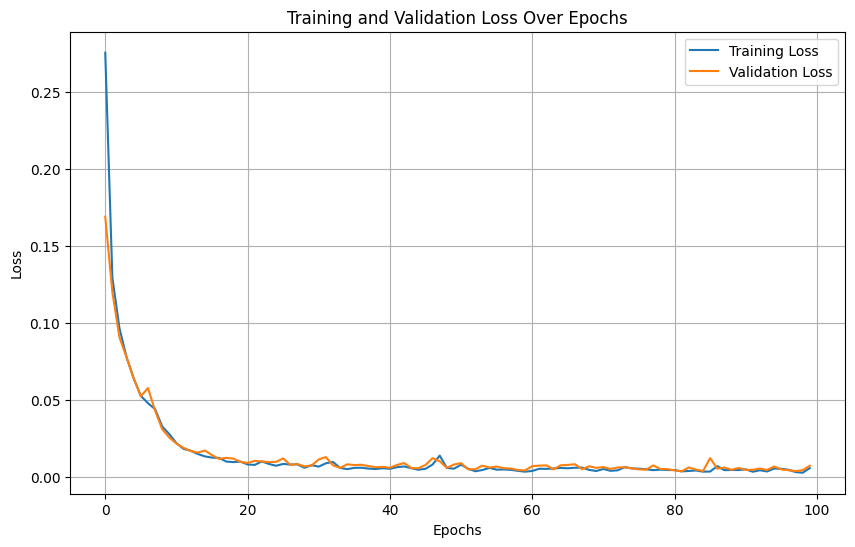

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Extracting Features
model.eval()

# Split the data with 80% training and 20% validation
train_data, val_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)

full_train_data = train_data + val_data
full_train_loader = DataLoader(full_train_data, batch_size=batch_size, shuffle=False)

all_features = []

with torch.no_grad():
    for data in full_train_loader:
        data = data.to(device)
        z, _ = model(data.x, data.edge_index, data.batch)  # Extracting the latent features (z)
        all_features.append(z.cpu().numpy())

extracted_features = np.vstack(all_features)


df = pd.DataFrame(extracted_features)
df.insert(0, 'graph_id', [data.graph_id for data in full_train_data])
df = df.sort_values(by=['graph_id'])

print(df)

df.to_csv('/content/gdrive/MyDrive/upenn/extracted_features1.csv', index=False)


     graph_id         0         1         2         3         4         5  \
340         0  0.013005 -0.127113 -0.169337 -0.440763  0.074613  0.011172   
255         1  0.014938  0.073781 -0.463828 -0.471016  0.085643 -0.093982   
145         2 -0.021563 -0.391683  0.116697 -0.621150  0.166513 -0.431225   
395         3 -0.090607 -0.307828  0.045340 -0.527533  0.020981 -0.267934   
198         4 -0.149093 -0.441326 -0.003519 -0.343452  0.211804 -0.176244   
..        ...       ...       ...       ...       ...       ...       ...   
384       392 -0.206997 -0.208755  0.773401  0.065206 -0.431934  0.257705   
6         393  0.037886 -0.310201  0.230743 -0.336165 -0.068195 -0.211390   
282       394 -0.017425 -0.025048 -0.405863 -0.438344  0.168982  0.007988   
44        395 -0.196877 -0.446170  0.306823 -0.109522 -0.114901  0.097972   
309       396  0.048069 -0.205598 -0.292594 -0.249885  0.171297  0.147665   

            6         7         8  ...        54        55        56  \
340